HFedCVAEGAN_5 265.91149044036865 0.8100339170419207 5
HFedCVAE_8 209.53639721870422 0.8123402978381058 7
HFedCVAEGAN_1 890.2931911945343 0.8108694839220082 97
HFedCGAN_2 842.7956223487854 0.7564262055342884 100
HFedCVAE_6 737.8298122882843 0.8104968584243188 82
HFedCVAEGAN_8 657.1460900306702 0.8105767292889219 54
HFedCGAN_3 825.4504117965698 0.7597880444560823 100
HFedCVAE_7 482.99722027778625 0.8127919625633856 46
HFedCGAN_5 2536.706170320511 0.8112506076667696 336
HFedCGAN_4 2767.3955070972443 0.8128246538917046 372
HFedCGAN_6 862.7079482078552 0.7654887882756414 100
HFedCVAE_1 219.24189114570618 0.8112504046447727 13
HFedCGAN_9 900.8525550365448 0.7346696269578571 100
HFedCGAN_1 845.4294910430908 0.7597281904761257 100
HFedCGAN_8 863.1470346450806 0.7465793262455795 100
HFedCGAN_10 871.3843810558319 0.7314632502560154 100
HFedCVAE_9 616.9546782970428 0.81289068923621 64
HFedCVAE_10 878.6712481975555 0.808540169803434 100
HFedCVAE_3 485.9415092468262 0.813666907950304 45
HFedCVAEGAN

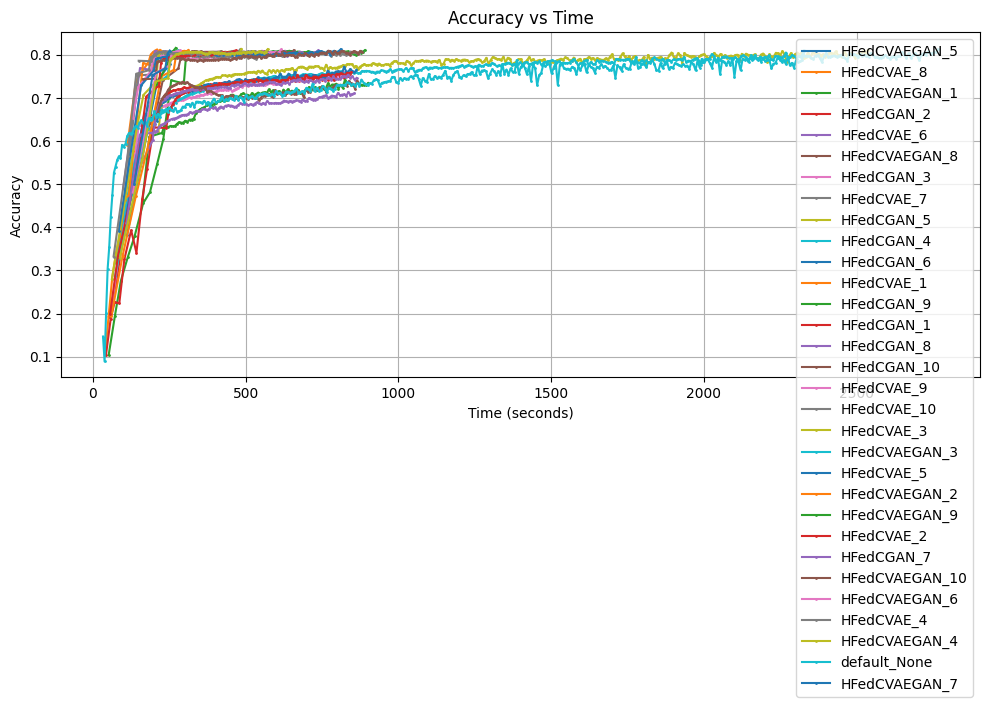

In [4]:
import os
import json
import ast
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# =========================
# CONFIG
# =========================
DATA_DIR = "../src/plots"
NAME_MAP_FILE = "algorithm_names.json"
target_accuracy = 0.81


# =========================
# HELPERS
# =========================
def load_dict(filepath):
    with open(filepath, "r") as f:
        content = f.read()
        try:
            return json.loads(content)
        except json.JSONDecodeError:
            return ast.literal_eval(content)


def parse_filename(filename):
    """
    default_5_7_claudiogsc_emnist_balance
    returns:
    algo=default, clients=5, classes=7, dataset=claudiogsc_emnist_balanced
    """
    parts = filename.split("_")
    algo_name = parts[0]

    if algo_name == "default":
        return algo_name, int(parts[1]), None, "_".join(parts[2:])
    return algo_name, int(parts[1]), int(parts[2]), "_".join(parts[3:])


# =========================
# COLLECT FILES
# =========================
results_files = {}
round_time_files = {}

for file in os.listdir(DATA_DIR):
    if file.endswith("_results.json"):
        key = file.replace("_results.json", "")
        results_files[key] = os.path.join(DATA_DIR, file)
    elif file.endswith("_round_times.json"):
        key = file.replace("_round_times.json", "")
        round_time_files[key] = os.path.join(DATA_DIR, file)

common_keys = set(results_files.keys()) & set(round_time_files.keys())

# =========================
# PROCESS DATA
# =========================
algo_data = {}

for key in common_keys:
    algo, clients, classes, dataset = parse_filename(key)

    unique_algo_key = f"{algo}_{classes}"

    # if unique_algo_key != "HFedCVAE_9":
    #     continue

    results = load_dict(results_files[key])
    times = load_dict(round_time_files[key])

    round_acc = defaultdict(list)

    for client_id, rounds in results.items():
        for rnd, data in rounds.items():
            round_acc[int(rnd)].append(data["metrics"]["accuracy"])

    rounds_sorted = sorted(round_acc.keys())

    avg_accuracy = []
    avg_time = []
    cumulative_time = 0
    final_round = 0
    for rnd in rounds_sorted:
        avg_accu = np.mean(round_acc[rnd])
        final_round = rnd

        if avg_accu >= target_accuracy:
            avg_accuracy.append(avg_accu)
            cumulative_time += times[str(rnd)]
            avg_time.append(cumulative_time)
            break

        avg_accuracy.append(avg_accu)
        cumulative_time += times[str(rnd)]
        avg_time.append(cumulative_time)

    algo_data[unique_algo_key] = {
        "algo": algo,
        "clients": clients,
        "classes": classes,
        "final_round": final_round,
        "accuracy": np.array(avg_accuracy),
        "time": np.array(avg_time),
    }

# =========================
# AUTO-MAINTAIN JSON FILE
# =========================
current_keys = set(algo_data.keys())

if not os.path.exists(NAME_MAP_FILE):
    # Create file initially
    name_map = {k: k for k in current_keys}
else:
    with open(NAME_MAP_FILE, "r") as f:
        name_map = json.load(f)

    # Remove stale entries
    for k in list(name_map.keys()):
        if k not in current_keys:
            del name_map[k]

    # Add missing entries
    for k in current_keys:
        if k not in name_map:
            name_map[k] = k

with open(NAME_MAP_FILE, "w") as f:
    json.dump(name_map, f, indent=4)

# =========================
# GRAPH 1 – Accuracy vs Time (GLOBAL SCALE)
# =========================
plt.figure(figsize=(10, 6))

for key, data in algo_data.items():
    label = name_map[key]
    x = data["time"]
    y = data["accuracy"]

    print(name_map[key], data["time"][-1], data["accuracy"][-1], data["final_round"])

    plt.plot(x, y, marker="o", markersize=1, linewidth=1.5, label=label)


plt.xlabel("Time (seconds)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# =========================
# GRAPH 2 – Relative Speed vs Default FL (WITH VALUES)
# =========================

default_key = "HFedCVAE_47"

default_time = algo_data[default_key]["time"][-1]

labels = []
speedups = []

for key, data in algo_data.items():
    algo_time = data["time"][-1]
    speedup_pct = (default_time - algo_time) / default_time * 100

    labels.append(name_map[key])
    speedups.append(speedup_pct)

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, speedups)
plt.axvline(0, linestyle="--", linewidth=1)

# ---- Annotate values on bars ----
for bar, val in zip(bars, speedups):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    label = f"{val:+.1f}%"
    offset = 1 if val >= 0 else -1

    plt.text(
        x + offset,
        y,
        label,
        va="center",
        ha="left" if val >= 0 else "right",
        fontsize=10,
    )

plt.xlabel("Speedup vs Default FL (%)")
plt.title("Training Speed Comparison (Higher is Faster)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.margins(x=0.1)
plt.tight_layout()
plt.show()

KeyError: 'HFedCVAE_47'

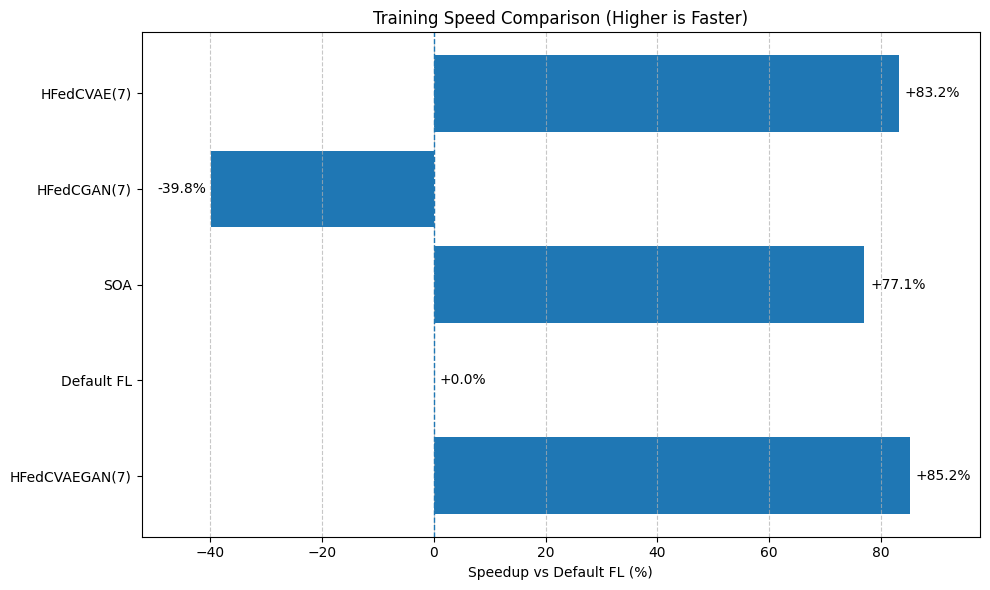

In [ ]:
# =========================
# GRAPH 2 – Relative Speed vs Default FL (WITH VALUES)
# =========================

default_key = "default_7"

default_time = algo_data[default_key]["time"][-1]

labels = []
speedups = []

for key, data in algo_data.items():
    algo_time = data["time"][-1]
    speedup_pct = (default_time - algo_time) / default_time * 100

    labels.append(name_map[key])
    speedups.append(speedup_pct)

plt.figure(figsize=(10, 6))
bars = plt.barh(labels, speedups)
plt.axvline(0, linestyle="--", linewidth=1)

# ---- Annotate values on bars ----
for bar, val in zip(bars, speedups):
    x = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    label = f"{val:+.1f}%"
    offset = 1 if val >= 0 else -1

    plt.text(
        x + offset,
        y,
        label,
        va="center",
        ha="left" if val >= 0 else "right",
        fontsize=10,
    )

plt.xlabel("Speedup vs Default FL (%)")
plt.title("Training Speed Comparison (Higher is Faster)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.margins(x=0.1)
plt.tight_layout()
plt.show()